In [1]:
# Load packages
from matplotlib import pyplot as plt
import sys
import csv
from os import listdir
from os.path import isfile, join
from collections import defaultdict
import networkx as nx

import lucem_illud_2020
import pandas as pd
import numpy as np

from pushshift_py import PushshiftAPI
api = PushshiftAPI()
import datetime as dt

import sklearn
import sklearn.metrics.pairwise
import sklearn.feature_extraction.text
import sklearn.cluster
import sklearn.decomposition
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from pyanno.measures import cohens_kappa
from sklearn.inspection import permutation_importance
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib
import matplotlib.pyplot as plt
import wordcloud
import gensim
import nltk
from collections import defaultdict
import math
import re
import textstat
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

As a reminder, the default subreddits are what people without an account see when they visit reddit.com, and the “starter set” of subscriptions when someone creates a new account. Most of the old default set was selected based on user activity and interest from years ago. reddit has grown and changed so much over the years that it’s only fair to increase the number of subreddits so we can showcase newer subreddits that reflect the interests of the current userbase. This is sort of an experiment… we plan on changing the defaults more often, and we are always looking for great subreddits to potentially add to the list. So once again, without further ado, here are our new defaults!

defaulted: 
2014: OldSchoolCool, nosleep, dataisbeautiful, nottheonion, ListenToThis, TwoXChromosomes
2013: EarthPorn, television, books
bumped:
atheism, politics

In [ ]:
# request comment data from 2013-2016 in r/listentothis from pushishift API
for year in range(2013, 2017):
    for month in range(1, 13):
        print("Requesting: ", year, month)
        start_epoch = int(dt.datetime(year, month, 1).timestamp())
        if month!= 12:
            end_epoch = int(dt.datetime(year, month+1, 1).timestamp())
        else:
            end_epoch = int(dt.datetime(year+1, 1, 1).timestamp())
        lst = list(api.search_comments(after=start_epoch,
                                    before=end_epoch,
                                    subreddit='listentothis'))

        commentList = [comment[-2] for comment in lst]    
        commentDF = pd.DataFrame(commentList)
        commentDF.to_csv("../Project/Data/comment_listentothis_"+str(year)+"_"+str(month)+".csv", index=False)
        print("{}.{}: ".format(year, month), start_epoch, min(commentDF.created_utc), max(commentDF.created_utc), end_epoch)

Turns out the API has very strict traffic limit. So I turned to BigQuery dumped dataset instead.

In [ ]:
# request submission data from 2013-2016 in r/listentothis from pushishift API
for year in range(2013, 2017):
    for month in range(1, 13):
        print("Requesting: ", year, month)
        start_epoch = int(dt.datetime(year, month, 1).timestamp())
        if month!= 12:
            end_epoch = int(dt.datetime(year, month+1, 1).timestamp())
        else:
            end_epoch = int(dt.datetime(year+1, 1, 1).timestamp())
        lst = list(api.search_submissions(after=start_epoch,
                                    before=end_epoch,
                                    subreddit='listentothis'))

        commentList = [comment[-2] for comment in lst]    
        commentDF = pd.DataFrame(commentList)
        commentDF.to_csv("../Project/Data/submission_listentothis_"+str(year)+"_"+str(month)+".csv", index=False)
        print("{}.{}: ".format(year, month), start_epoch, min(commentDF.created_utc), max(commentDF.created_utc), end_epoch, "Number of posts: ", commentDF.shape[0])

In [ ]:
# request posts data from pushshift API
# 25 records per request
import requests
import json
import time

submissions = []
start_epoch = str(int(dt.datetime(2013, 1, 1).timestamp()))
end_epoch = str(int(dt.datetime(2016, 12, 31).timestamp()))
url = 'https://api.pushshift.io/reddit/submission/search/?after='+start_epoch+'&before='+end_epoch+'&subreddit=listentothis&sort_type=created_utc&sort=asc'
r = requests.get(url)
submissionData = json.loads(r.text)['data']
for x in submissionData:
    submissions.append(x)
pd.DataFrame(submissions).to_csv('../Project/Data/bigquery/submission_listentothis.csv', mode = 'w', sep = ',', encoding='utf-8', header=True, index=False)
last_epoch = str(submissionData[-1]['created_utc'])

In [61]:
while len(submissionData)>=25:
    submissions = []
    url = 'https://api.pushshift.io/reddit/submission/search/?after='+last_epoch+'&before='+end_epoch+'&after_id='+last_id+'&subreddit=listentothis&sort_type=created_utc&sort=asc'
    r = requests.get(url)
    if r.status_code==200:
        submissionData = json.loads(r.text)['data']
        print(dt.datetime.fromtimestamp(submissionData[0]['created_utc']).strftime("%y-%m-%d"), last_epoch)
        for x in submissionData:
            submissions.append(x)
        pd.DataFrame(submissions).to_csv('../Project/Data/bigquery/submission_listentothis.csv', mode = 'a', sep = ',', encoding='utf-8', header=False, index=False)
        last_epoch = str(submissionData[-1]['created_utc'])
        time.sleep(5)
    else:
        time.sleep(20)

13-08-04 1375646554
13-08-04 1375657192
13-08-04 1375673657
13-08-05 1375690585
13-08-05 1375713485
13-08-05 1375724305
13-08-05 1375734182
13-08-05 1375743275
13-08-05 1375754232
13-08-06 1375770732
13-08-06 1375783219
13-08-06 1375795865
13-08-06 1375805722
13-08-06 1375811033
13-08-06 1375817319
13-08-06 1375827257
13-08-06 1375842758
13-08-06 1375848673
13-08-07 1375856406
13-08-07 1375877568
13-08-07 1375890270
13-08-07 1375898798
13-08-07 1375906631
13-08-07 1375915213
13-08-07 1375921432
13-08-07 1375930879
13-08-08 1375943743
13-08-08 1375963781
13-08-08 1375973086
13-08-08 1375978649
13-08-08 1375986082
13-08-08 1375993886
13-08-08 1376005098
13-08-08 1376012224
13-08-09 1376024728
13-08-09 1376044700
13-08-09 1376057071
13-08-09 1376062335
13-08-09 1376067550
13-08-09 1376072149
13-08-09 1376077163
13-08-09 1376082334
13-08-09 1376088938
13-08-09 1376097635
13-08-09 1376107969
13-08-10 1376120385
13-08-10 1376146717
13-08-10 1376156756
13-08-10 1376165543
13-08-10 1376176117


13-09-23 1379913295
13-09-23 1379928841
13-09-23 1379941382
13-09-23 1379951021
13-09-23 1379960990
13-09-23 1379967646
13-09-23 1379973999
13-09-23 1379980981
13-09-23 1379991080
13-09-24 1380000686
13-09-24 1380018211
13-09-24 1380035713
13-09-24 1380044322
13-09-24 1380049243
13-09-24 1380056336
13-09-24 1380065463
13-09-24 1380073749
13-09-25 1380087234
13-09-25 1380103303
13-09-25 1380115847
13-09-25 1380122840
13-09-25 1380129180
13-09-25 1380138241
13-09-25 1380144893
13-09-25 1380156074
13-09-25 1380164438
13-09-26 1380177188
13-09-26 1380201126
13-09-26 1380215126
13-09-26 1380224298
13-09-26 1380232638
13-09-26 1380240988
13-09-27 1380259258
13-09-27 1380271159
13-09-27 1380287627
13-09-27 1380296720
13-09-27 1380303411
13-09-27 1380309766
13-09-27 1380317298
13-09-27 1380327085
13-09-28 1380345735
13-09-28 1380365250
13-09-28 1380382886
13-09-28 1380393540
13-09-28 1380408369
13-09-28 1380421223
13-09-29 1380441980
13-09-29 1380460260
13-09-29 1380472396
13-09-29 1380479898


13-11-12 1384274363
13-11-12 1384280285
13-11-12 1384286651
13-11-12 1384296897
13-11-12 1384301260
13-11-12 1384310812
13-11-12 1384316617
13-11-13 1384324559
13-11-13 1384339344
13-11-13 1384353863
13-11-13 1384363204
13-11-13 1384372071
13-11-13 1384377465
13-11-13 1384384469
13-11-13 1384393340
13-11-13 1384398324
13-11-13 1384406405
13-11-14 1384419000
13-11-14 1384433597
13-11-14 1384443127
13-11-14 1384448641
13-11-14 1384453834
13-11-14 1384458891
13-11-14 1384465236
13-11-14 1384469004
13-11-14 1384474226
13-11-14 1384482394
13-11-14 1384488507
13-11-14 1384494703
13-11-15 1384502378
13-11-15 1384519518
13-11-15 1384529652
13-11-15 1384536889
13-11-15 1384544716
13-11-15 1384551516
13-11-15 1384560230
13-11-15 1384571664
13-11-16 1384586502
13-11-16 1384614445
13-11-16 1384627023
13-11-16 1384636288
13-11-16 1384645220
13-11-16 1384653737
13-11-17 1384669524
13-11-17 1384689581
13-11-17 1384706190
13-11-17 1384716700
13-11-17 1384723945
13-11-17 1384735802
13-11-17 1384746581


13-12-27 1388190301
13-12-27 1388201434
13-12-28 1388211561
13-12-28 1388231439
13-12-28 1388249715
13-12-28 1388259972
13-12-28 1388270741
13-12-28 1388283740
13-12-28 1388292030
13-12-29 1388311064
13-12-29 1388332629
13-12-29 1388343774
13-12-29 1388356314
13-12-29 1388369863
13-12-29 1388380430
13-12-30 1388399922
13-12-30 1388414460
13-12-30 1388425574
13-12-30 1388433213
13-12-30 1388442962
13-12-30 1388456639
13-12-30 1388465212
13-12-31 1388481759
13-12-31 1388505573
13-12-31 1388513747
13-12-31 1388526125
13-12-31 1388538799
14-01-01 1388561250
14-01-01 1388594188
14-01-01 1388603985
14-01-01 1388612528
14-01-01 1388622471
14-01-01 1388634149
14-01-02 1388642663
14-01-02 1388668206
14-01-02 1388680391
14-01-02 1388687689
14-01-02 1388692573
14-01-02 1388703161
14-01-02 1388712801
14-01-02 1388721374
14-01-03 1388730924
14-01-03 1388739922
14-01-03 1388756655
14-01-03 1388768306
14-01-03 1388774391
14-01-03 1388779006
14-01-03 1388785450
14-01-03 1388791634
14-01-03 1388800429


14-02-11 1392161197
14-02-11 1392168202
14-02-11 1392173323
14-02-11 1392181013
14-02-12 1392193533
14-02-12 1392206204
14-02-12 1392217852
14-02-12 1392225320
14-02-12 1392230202
14-02-12 1392234620
14-02-12 1392239839
14-02-12 1392246208
14-02-12 1392252139
14-02-12 1392257270
14-02-12 1392261793
14-02-13 1392272218
14-02-13 1392287999
14-02-13 1392303383
14-02-13 1392311739
14-02-13 1392317657
14-02-13 1392321984
14-02-13 1392326368
14-02-13 1392330868
14-02-13 1392336166
14-02-13 1392343205
14-02-13 1392349449
14-02-14 1392359043
14-02-14 1392367243
14-02-14 1392385258
14-02-14 1392394063
14-02-14 1392398311
14-02-14 1392402541
14-02-14 1392408369
14-02-14 1392411095
14-02-14 1392416517
14-02-14 1392424398
14-02-14 1392431801
14-02-14 1392440746
14-02-15 1392453239
14-02-15 1392472047
14-02-15 1392483777
14-02-15 1392489297
14-02-15 1392494913
14-02-15 1392503086
14-02-15 1392513812
14-02-15 1392523918
14-02-16 1392537054
14-02-16 1392556231
14-02-16 1392567217
14-02-16 1392574282


14-03-23 1395620366
14-03-23 1395629127
14-03-24 1395636968
14-03-24 1395657888
14-03-24 1395669028
14-03-24 1395676076
14-03-24 1395683111
14-03-24 1395688077
14-03-24 1395694073
14-03-24 1395698875
14-03-24 1395709554
14-03-24 1395715523
14-03-25 1395724182
14-03-25 1395744026
14-03-25 1395758962
14-03-25 1395767003
14-03-25 1395774487
14-03-25 1395780265
14-03-25 1395785980
14-03-25 1395793311
14-03-25 1395800708
14-03-25 1395806288
14-03-26 1395813430
14-03-26 1395830393
14-03-26 1395846716
14-03-26 1395854702
14-03-26 1395861964
14-03-26 1395867930
14-03-26 1395874072
14-03-26 1395881522
14-03-26 1395889665
14-03-27 1395898794
14-03-27 1395918797
14-03-27 1395931507
14-03-27 1395938271
14-03-27 1395944750
14-03-27 1395952843
14-03-27 1395960136
14-03-27 1395968945
14-03-27 1395977868
14-03-28 1395984197
14-03-28 1396003529
14-03-28 1396018400
14-03-28 1396025339
14-03-28 1396030955
14-03-28 1396036611
14-03-28 1396043119
14-03-28 1396049364
14-03-28 1396056160
14-03-29 1396073687


14-05-07 1399498680
14-05-07 1399501376
14-05-07 1399504483
14-05-07 1399508345
14-05-07 1399510866
14-05-07 1399513330
14-05-07 1399518067
14-05-07 1399520610
14-05-08 1399525613
14-05-08 1399531290
14-05-08 1399540893
14-05-08 1399549075
14-05-08 1399556970
14-05-08 1399561201
14-05-08 1399565789
14-05-08 1399570228
14-05-08 1399573428
14-05-08 1399579214
14-05-08 1399582652
14-05-08 1399587134
14-05-08 1399591908
14-05-08 1399598570
14-05-08 1399603949
14-05-08 1399608296
14-05-09 1399615082
14-05-09 1399623596
14-05-09 1399632067
14-05-09 1399640142
14-05-09 1399645805
14-05-09 1399649527
14-05-09 1399655224
14-05-09 1399659654
14-05-09 1399662817
14-05-09 1399666557
14-05-09 1399671238
14-05-09 1399675806
14-05-09 1399681931
14-05-09 1399686725
14-05-09 1399692218
14-05-10 1399700027
14-05-10 1399714836
14-05-10 1399726511
14-05-10 1399734329
14-05-10 1399739267
14-05-10 1399744725
14-05-10 1399751337
14-05-10 1399757832
14-05-10 1399766907
14-05-10 1399772439
14-05-10 1399777886


14-06-12 1402588839
14-06-12 1402595169
14-06-12 1402600748
14-06-12 1402606259
14-06-12 1402611167
14-06-12 1402615342
14-06-12 1402621048
14-06-12 1402631797
14-06-13 1402641494
14-06-13 1402653419
14-06-13 1402662848
14-06-13 1402669431
14-06-13 1402676959
14-06-13 1402681751
14-06-13 1402686302
14-06-13 1402693821
14-06-13 1402699469
14-06-13 1402703303
14-06-13 1402710819
14-06-13 1402719193
14-06-14 1402728018
14-06-14 1402740167
14-06-14 1402750242
14-06-14 1402760931
14-06-14 1402767566
14-06-14 1402775356
14-06-14 1402786105
14-06-14 1402796494
14-06-14 1402806772
14-06-15 1402823789
14-06-15 1402833855
14-06-15 1402842829
14-06-15 1402851192
14-06-15 1402857830
14-06-15 1402865345
14-06-15 1402870904
14-06-15 1402879170
14-06-15 1402884480
14-06-15 1402893609
14-06-16 1402901598
14-06-16 1402910600
14-06-16 1402924100
14-06-16 1402930808
14-06-16 1402938196
14-06-16 1402945122
14-06-16 1402950073
14-06-16 1402957781
14-06-16 1402965020
14-06-16 1402971948
14-06-16 1402980328


14-07-18 1405727083
14-07-18 1405731841
14-07-18 1405740411
14-07-19 1405747037
14-07-19 1405756439
14-07-19 1405772225
14-07-19 1405781828
14-07-19 1405788702
14-07-19 1405794740
14-07-19 1405800714
14-07-19 1405809948
14-07-19 1405820918
14-07-19 1405827232
14-07-19 1405831155
14-07-20 1405841685
14-07-20 1405858035
14-07-20 1405870293
14-07-20 1405877785
14-07-20 1405885402
14-07-20 1405889773
14-07-20 1405895411
14-07-20 1405901900
14-07-20 1405908470
14-07-20 1405915091
14-07-21 1405925138
14-07-21 1405936075
14-07-21 1405947822
14-07-21 1405957184
14-07-21 1405964800
14-07-21 1405970196
14-07-21 1405974395
14-07-21 1405978271
14-07-21 1405982953
14-07-21 1405990129
14-07-21 1405995827
14-07-21 1406002163
14-07-22 1406006119
14-07-22 1406015204
14-07-22 1406026392
14-07-22 1406033912
14-07-22 1406040948
14-07-22 1406045894
14-07-22 1406052251
14-07-22 1406056280
14-07-22 1406060569
14-07-22 1406065792
14-07-22 1406070100
14-07-22 1406076174
14-07-22 1406081145
14-07-22 1406089153


KeyboardInterrupt: 

In [59]:
requests.get(url).status_code

200

In [ ]:
def epoch_date(epoch):
    return dt.datetime.fromtimestamp(epoch).strftime("%y-%m-%d")

def date_epoch(y, m, d):
    return int(dt.datetime(y, m, d).timestamp())

### Select columns

In [ ]:
commentList = [comment[-2] for comment in lst]    
commentDF = pd.DataFrame(commentList)
commentDF.to_csv("../Project/Data/bigquery/comment_listentothis_2013.csv", index=False)
print(commentDF.shape)

In [91]:
# select columns
commentDF = pd.read_csv("../Project/Data/comment_listentothis.csv")
print(commentDF.columns.values)
commentDF = commentDF[['author', 'author_created_utc', 
       'author_flair_text', 'author_fullname', 'body', 'controversiality',
       'created_utc', 'distinguished', 'edited', 'gilded', 'id',
       'link_id', 'nest_level', 'parent_id', 'reply_delay',
       'retrieved_on', 'score', 'score_hidden', 'user_removed']]

['author' 'author_created_utc' 'author_flair_css_class'
 'author_flair_text' 'author_fullname' 'body' 'controversiality'
 'created_utc' 'distinguished' 'edited' 'gilded' 'id' 'link_id'
 'nest_level' 'parent_id' 'reply_delay' 'retrieved_on' 'score'
 'score_hidden' 'subreddit' 'subreddit_id' 'user_removed']


#### Genres

In [2]:
#select columns
import csv
lst = []
with open("../Project/Data/bigquery/submission_listentothis.csv", encoding="utf-8") as f:
    reader = csv.reader(f, delimiter=",")
    for i, row in enumerate(reader):
        dic = {}
        dic['created_utc'] = row[5]
        dic['title'] = row[-3]
        lst.append(dic)
            
submissionDF = pd.DataFrame(lst)
#submissionDF_16 = pd.read_csv("../Project/Data/bigquery/submission_listentothis_2016.csv")
#print(submissionDF.columns.values)
#submissionDF = submissionDF[['author', 'author_created_utc', 'author_fullname', 'created_utc', 
#                             'id', 'media', 'num_comments', 'score', 'title', 'url']]
#submissionDF_16 = submissionDF_16[['author', 'created_utc', 'id', 'num_comments', 'score', 'title', 'url']]

In [88]:
submissionDF = submissionDF[1:]

In [90]:
submissionDF.head()

,created_utc,title,genre
1,1357020292,"Roger Whittaker - Mexican Whistler (Errrmm, Wh...","[Errrmm, Whistle folk? Basically, it's the bes..."
2,1357021151,&lt;&lt;K.A.I.N&gt;&gt; - One Synth + effects ...,"[Melodic Trance, new]"
3,1357021509,Ta-ku - Higher (Flume Remix) [Hip-Hop Instrume...,"[Flume Remix, Hip-Hop Instrumental]"
4,1357022079,&lt;&lt;K.A.I.N&gt;&gt; - Forever Al1 [Trance]...,"[Trance, new]"
5,1357022891,Alabama Shakes - On Your Way [Blues Rock?],[Blues Rock?]


In [24]:
submissionDF['genre'] = submissionDF['title'].apply(lambda x: ["".join(pat) for pat in re.findall("\((.*?)\)|\[(.*?)\]", x)])

In [4]:
submissionDF.genre[:20].sum()

["Errrmm, Whistle folk? Basically, it's the best whistling you'll ever hear. You'll put up some sort of resistance,  and then gladly let your mind succumb to it",
 'Melodic Trance',
 'new',
 'Flume Remix',
 'Hip-Hop Instrumental',
 'Trance',
 'new',
 'Blues Rock?',
 'Piano',
 'Australian Blues-Rock',
 'ft. Fontella Bass',
 'downtempo / blues',
 'dubstep, electronic',
 'Indie rock',
 'Experimental/Electronic',
 'Mali Folk',
 '3:58',
 'Indie Electronic',
 'Feat. Substantial',
 'Hip Hop, Nu Jazz',
 'Jazz',
 'Avant-garde metal']

In [25]:
import nltk
def remove_url(comment):
    s =' '.join([s for s in nltk.tokenize.casual_tokenize(comment)if 'http' not in s])
    return s
submissionDF['genre'] = submissionDF['genre'].apply(lambda x: str([str(word) for word in x]))
#submissionDF['tokenized_genre'] = submissionDF['genre'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
submissionDF['normalized_genre'] = submissionDF['genre'].apply(lambda x: [lucem_illud_2020.normalizeTokens(x, lemma=False)])
submissionDF.head()

,created_utc,title,genre,normalized_genre
0,created_utc,title,[],[[]]
1,1357020292,"Roger Whittaker - Mexican Whistler (Errrmm, Wh...","[""Errrmm, Whistle folk? Basically, it's the be...","[[errrmm, whistle, folk, basically, best, whis..."
2,1357021151,&lt;&lt;K.A.I.N&gt;&gt; - One Synth + effects ...,"['Melodic Trance', 'new']","[[melodic, trance, new]]"
3,1357021509,Ta-ku - Higher (Flume Remix) [Hip-Hop Instrume...,"['Flume Remix', 'Hip-Hop Instrumental']","[[flume, remix, hip, hop, instrumental]]"
4,1357022079,&lt;&lt;K.A.I.N&gt;&gt; - Forever Al1 [Trance]...,"['Trance', 'new']","[[trance, new]]"


In [45]:
import ast
submissionDF['normalized_genre'] = submissionDF['normalized_genre'].apply(lambda x: sum(x, []))
submissionDF.head()

,created_utc,title,genre,normalized_genre
0,created_utc,title,[],[]
1,1357020292,"Roger Whittaker - Mexican Whistler (Errrmm, Wh...","[""Errrmm, Whistle folk? Basically, it's the be...","[errrmm, whistle, folk, basically, best, whist..."
2,1357021151,&lt;&lt;K.A.I.N&gt;&gt; - One Synth + effects ...,"['Melodic Trance', 'new']","[melodic, trance, new]"
3,1357021509,Ta-ku - Higher (Flume Remix) [Hip-Hop Instrume...,"['Flume Remix', 'Hip-Hop Instrumental']","[flume, remix, hip, hop, instrumental]"
4,1357022079,&lt;&lt;K.A.I.N&gt;&gt; - Forever Al1 [Trance]...,"['Trance', 'new']","[trance, new]"


In [53]:
for title in submissionDF['normalized_genre'][:20].sum():
    print(title)

errrmm
whistle
folk
basically
best
whistling
hear
sort
resistance
gladly
let
mind
succumb
melodic
trance
new
flume
remix
hip
hop
instrumental
trance
new
blues
rock
piano
australian
blues
rock
ft
fontella
bass
downtempo
blues
dubstep
electronic
indie
rock
experimental
electronic
mali
folk
3:58
indie
electronic
feat
substantial
hip
hop
nu
jazz
jazz
avant
garde
metal


In [56]:
countsDict = {}
i = 0
for title in submissionDF['normalized_genre'].sum():
    if title in countsDict:
        countsDict[title] += 1
    else:
        countsDict[title] = 1
    i = i+1
    if i%1000==0:
        print(i)
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [63]:
top50 = {x[0]:x[1] for x in word_counts[:50]}

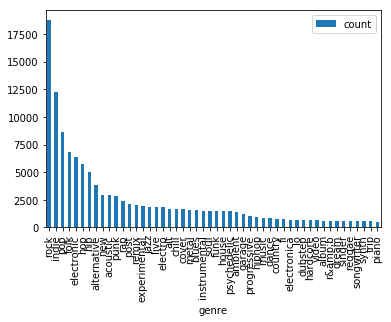

In [70]:
df_top = pd.DataFrame(top50.items(), columns=['genre', 'count'])
#top50
df_top.plot.bar(x='genre', y='count')

In [72]:
submissionDF.to_csv('../Project/Data/bigquery/cleaned_submission.csv', sep=',')

### Filtering and Normalizing Comments

In [19]:
import os.path
corpus_name = "/Users/Nancy/Desktop/2020 Spring/Textual Analysis/Project/data/bigquery/comment"

#corpus_name = "Movies"
os.listdir(corpus_name + "/")

['comment_listentothis_2013.csv',
 'comment_listentothis_2014.csv',
 'comment_listentothis_2015_01.csv',
 'comment_listentothis_2015_02.csv',
 'comment_listentothis_2015_03.csv',
 'comment_listentothis_2015_04.csv',
 'comment_listentothis_2015_05.csv',
 'comment_listentothis_2015_06.csv',
 'comment_listentothis_2015_07.csv',
 'comment_listentothis_2015_08.csv',
 'comment_listentothis_2015_09.csv',
 'comment_listentothis_2015_10.csv',
 'comment_listentothis_2015_11.csv',
 'comment_listentothis_2015_12.csv',
 'comment_listentothis_2016_01.csv',
 'comment_listentothis_2016_02.csv',
 'comment_listentothis_2016_03.csv',
 'comment_listentothis_2016_04.csv',
 'comment_listentothis_2016_05.csv',
 'comment_listentothis_2016_06.csv',
 'comment_listentothis_2016_07.csv',
 'comment_listentothis_2016_08.csv',
 'comment_listentothis_2016_09.csv',
 'comment_listentothis_2016_10.csv',
 'comment_listentothis_2016_11.csv',
 'comment_listentothis_2016_12.csv']

In [39]:
def tokenize_normalize(corpus_name, corpus_style="csv"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            commentDF = pd.read_csv(corpus_name + "/" + file)
            commentDF = commentDF[commentDF['body'].str.contains('http|[deleted]')==False]
            earliest = dt.datetime.fromtimestamp(min(commentDF.created_utc)).strftime("%y-%m-%d")
            latest = dt.datetime.fromtimestamp(max(commentDF.created_utc)).strftime("%y-%m-%d")

            commentDF = commentDF[['author', 'name', 'body', 'controversiality', 'created_utc', 
                'distinguished',  'gilded', 'id', 'link_id', 'parent_id', 'retrieved_on', 'score', 'score_hidden']]
            print(file, earliest, latest, commentDF.shape[0])
            print('Tokenizing:')
            commentDF['tokenized_sents'] = commentDF['body'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
            print('Normalizing:')
            commentDF['normalized_sents'] = commentDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
            commentDF.to_csv("../Project/Data/processed/processed_"+ file, index=False)

tokenize_normalize(corpus_name)

comment_listentothis_2013.csv 12-12-31 13-12-31
Tokenizing:
Normalizing:
comment_listentothis_2014.csv 14-01-01 14-12-30
Tokenizing:
Normalizing:
comment_listentothis_2015_01.csv 15-01-02 15-01-29
Tokenizing:
Normalizing:
comment_listentothis_2015_02.csv 15-01-31 15-02-28
Tokenizing:
Normalizing:
comment_listentothis_2015_03.csv 15-03-02 15-03-31
Tokenizing:
Normalizing:
comment_listentothis_2015_04.csv 15-03-31 15-04-30
Tokenizing:
Normalizing:
comment_listentothis_2015_05.csv 15-04-30 15-05-30
Tokenizing:
Normalizing:
comment_listentothis_2015_06.csv 15-05-31 15-06-30
Tokenizing:
Normalizing:
comment_listentothis_2015_07.csv 15-07-01 15-07-31
Tokenizing:
Normalizing:
comment_listentothis_2015_08.csv 15-07-31 15-08-30
Tokenizing:
Normalizing:
comment_listentothis_2015_09.csv 15-09-01 15-09-30
Tokenizing:
Normalizing:
comment_listentothis_2015_10.csv 15-09-30 15-10-31
Tokenizing:
Normalizing:
comment_listentothis_2015_11.csv 15-11-01 15-11-30
Tokenizing:
Normalizing:
comment_listentoth

In [38]:
commentDF = pd.read_csv(corpus_name + "/" + "comment_listentothis_2013.csv")
commentDF = commentDF[commentDF['body'].str.contains('http|[deleted]')==False]
commentDF['tokenized_sents'] = commentDF['body'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])

In [152]:
#import lucem_illud_2020

#commentDF['tokenized_sents'] = commentDF['body'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
#commentDF['normalized_sents'] = commentDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
submissionDF['tokenized_title'] = submissionDF['title'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
submissionDF['normalized_title'] = submissionDF['tokenized_title'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

In [37]:
commentDF.head()

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,...,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,tokenized_sents
327,Thanks!,False,True,t1_c7tlvuq,ProjectL1,bandcamp,0,1357702054,t5_2qxzy,t3_167gi1,...,1,1430901570,0,0,c7tlvuq,listentothis,1,NaN,bandcamp,[Thanks!]
724,YES,False,True,t1_c98aria,jonar33,NaN,0,1365078825,t5_2qxzy,t3_1bnhvf,...,1,1431676923,0,0,c98aria,listentothis,1,NaN,NaN,[YES]
767,Wow....,False,True,t1_cb0itxs,Kallard,NaN,0,1373560531,t5_2qxzy,t3_1i2yb3,...,2,1430504557,0,0,cb0itxs,listentothis,2,NaN,NaN,[Wow....]
949,Thank you!,False,True,t1_c9vsnag,Hoplite1,NaN,0,1368141394,t5_2qxzy,t3_1e05x3,...,2,1431244810,0,0,c9vsnag,listentothis,2,NaN,NaN,[Thank you!]
989,WHAT THE FUCK?????,False,True,t1_cafgmd5,SavoryTrouserTrout,NaN,0,1370813134,t5_2qxzy,t3_1g03nd,...,7,1430869337,0,0,cafgmd5,listentothis,7,NaN,NaN,"[WHAT THE FUCK??, ?, ??]"


In [151]:
#commentDF.to_csv("../Project/Data/processed/processed_comment_listentothis.csv", index=False)
submissionDF.to_csv("../Project/Data/processed/processed_submission_listentothis.csv", index=False)